# Close to Close Statistics 

In [1]:
import os
import copy
import random
import datetime
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from matplotlib.transforms import Affine2D
from pandas.plotting import autocorrelation_plot

## 1. Exploratory Data Analysis

### 1.1 Load and Arrange data

In [2]:
# Load dataset
df = pd.read_csv('TradesCleaned.csv')

In [3]:
# Create figures file
directory = os.getcwd()
if not os.path.exists(os.path.join(directory,'figures')):
    os.makedirs(os.path.join(directory,'figures'))

In [4]:
df.dtypes

valueDate     object
family        object
spread       float64
size         float64
dtype: object

In [5]:
df['valueDate'] = pd.to_datetime(df['valueDate'])
df.set_index('valueDate', inplace=True)

In [6]:
df.dtypes

family     object
spread    float64
size      float64
dtype: object

### 1.2 Weighted Daily Mean Spread

For each credit index swap family we have a range of trades that occur every day. We therefore can concentrate on two aspects of the operation, close to close and intra day metrics. Therefore, at first we will concentrate on the close to close aspect of this time series. 

We need to aggregate each the data in a single day of trading to a single metric for each family. As a consequence, we used the weighted mean. This metric has the following equation:

$$ Spread_{weighted, t} = \frac{\sum_{i=0}^{N} Spread_{i,t}*Size_{i,t}}{\sum_{i=0}^{N}Size_{i,t}} $$

Where N is the total number of trades, i represents the ith trade for that day, and t the day of that transaction. Each index family has its own value for each day it traded. 

In [7]:
df

,family,spread,size
valueDate,,,
2013-01-31 15:35:46,CDXEM,229.9410,5000000.0
2013-01-31 16:15:27,CDXEM,232.5927,7000000.0
2013-01-31 17:07:08,CDXEM,229.9410,10000000.0
2013-01-31 17:15:32,CDXEM,233.0010,4000000.0
2013-01-31 19:11:59,CDXEM,232.5927,20000000.0
...,...,...,...
2020-04-08 10:33:07,ITXEX,545.5000,5000000.0
2020-04-08 10:33:39,ITXEX,547.5000,15000000.0
2020-04-08 10:41:48,ITXEX,549.5000,10000000.0


In [43]:
# groupby family and by day
g = df.groupby(['family',pd.Grouper(freq='D')])
# Create variable of weighted mean of spreads by size of transaction per day
df_statistics = g.apply(lambda x: pd.Series([np.average(x['spread'], weights=x['size'])], index =['SpreadWeightedMean']))
# Create variable of mean of spreads of trades per day
df_statistics['SpreadMean'] = df.groupby(['family',pd.Grouper(freq = 'D')]).agg({'spread':'mean'})
# Create variable of log of spreads
df_statistics['LogSpreadWeightedMean'] = np.log(df_statistics['SpreadWeightedMean'])

In [44]:
# Reinitialise index and sort by time
df_statistics.reset_index(inplace=True)
df_statistics.sort_values('valueDate', inplace=True)

In [45]:
# Compute the variation of log of spreads
df_statistics['Returns'] = df_statistics.groupby(['family'])['LogSpreadWeightedMean'].diff()

In [46]:
df_statistics.isna().sum()

family                    0
valueDate                 0
SpreadWeightedMean        2
SpreadMean                0
LogSpreadWeightedMean     2
Returns                  10
dtype: int64

In [47]:
df_statistics.dropna(inplace=True)

In [48]:
df_statistics.isna().sum()

family                   0
valueDate                0
SpreadWeightedMean       0
SpreadMean               0
LogSpreadWeightedMean    0
Returns                  0
dtype: int64

## 2 Correlation Returns

### 2.1 Correlation Whole Dataset 

In this section we will consider the close to close correlation between the returns of each family type.
The Returns are defined as follows:
$$ R_{t} = \log(Spread_{t}) - \log(Spread_{t-1}) = \log(\frac{Spread_{t}}{Spread_{t-1}})$$

Where $R_{t}$ is the return at time t, $Spread_{t}$ is the spread at day t at $Spread_{t-1}$ is the spread at day t-1. 

We will analyse the correlation between the returns of the spreads, using different tpyes of correlation coefficients, in particular the Pearson and spearman correlation coefficients.

The pearson coefficient measures the linear correlation between two variables $X$ and $Y$. IF the coefficient is positive then both values lie on the same side of their respective means, and the higher the absolute value of the coefficient the higher the absolute value. It is defined as follows:

$$ \rho_{pearson,(X,Y)} = \frac{Cov(X,Y)}{\sigma_{X}\sigma_{Y}} = \frac{E[(X- \mu_{X})(Y - \mu_{Y})]}{\sigma_X \sigma_Y}$$

The Spearman coefficient is the defined as the Pearson's correlation coefficient between rank variables. It assesses how easily the relationship between two variables can be described using a montomic function. Similarly, a positive correlation shows that X increases then Y has a tendency to decrease, and a negative shows that when X increases then Y has a tendency to decrease.  
$$ \rho_{Spearman, (X,Y)} = \frac{Cov(R_{X},R_{Y})}{\sigma_{R_X}\sigma_{R_Y}}  $$
Where $R_{X}$ and $R_{Y}$ are respectively the ranks of X and Y. 

In [49]:
# Select only variation of log spread (returns) as well as valueDate and family columns and unstack columns such that have 1 column for the variation of the spread for each family type
df_return = df_statistics.loc[:,['family','valueDate','Returns']].set_index(['family','valueDate']).unstack(level=0)

In [50]:
df_return.shape

(1925, 6)

In [51]:
# Keep only rows where each family of index have at least one trade on that day
df_return.dropna(inplace=True)

In [52]:
df_return.isna().sum()

         family
Returns  CDXEM     0
         CDXHY     0
         CDXIG     0
         ITXEB     0
         ITXES     0
         ITXEX     0
dtype: int64

In [53]:
df_return.shape

(1734, 6)

In [54]:
# rename columns
df_return.columns = list(df_return.columns.get_level_values(level=1))

In [55]:
# Correlation pandas data frame
df_return.corr()

,CDXEM,CDXHY,CDXIG,ITXEB,ITXES,ITXEX
CDXEM,1.000000,0.615715,0.603021,0.566903,0.521738,0.525218
CDXHY,0.615715,1.000000,0.802778,0.695058,0.621908,0.675821
CDXIG,0.603021,0.802778,1.000000,0.790668,0.696062,0.720973
ITXEB,0.566903,0.695058,0.790668,1.000000,0.911037,0.849127
ITXES,0.521738,0.621908,0.696062,0.911037,1.000000,0.797935
ITXEX,0.525218,0.675821,0.720973,0.849127,0.797935,1.000000


In [56]:
def CorrelationHeatmap(df):
    '''
    Computes the correlation coefficients for the df return data frame
    Args:
        df: pandas df, return data frame
    Outputs:
        heatmap plot for the correlation coefficients
    '''
    # correlation coefficient methods
    coefficients = ['pearson', 'spearman']
    fig, a = plt.subplots(1,2,figsize=(12,6))
    
    for index, coefficient in enumerate(coefficients):
        # compute correlation coefficient
        cor = df.corr(method = coefficient)
        sns.heatmap(cor, annot=True, cmap="YlGnBu", ax=a[index])
        a[index].set(title = '2013-2020 Returns Correlation ' + coefficient)
        plt.xlabel('', fontsize = 15) # x-axis label with fontsize 15
        plt.ylabel('', fontsize = 15) # x-axis label with fontsize 15
    plt.savefig('figures/2013-2020_Weighted_Spread_Variation.eps',format='eps')
    plt.show()

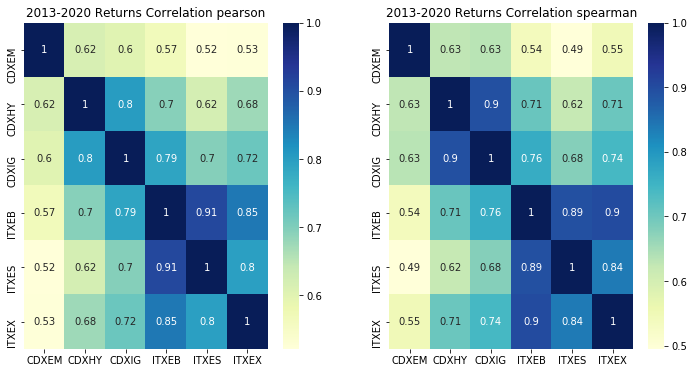

In [57]:
# Compute correlation heatmap whole dataset for both coefficients
CorrelationHeatmap(df_return)

After analysing the subplots we can see that there is a strong underlying correlation between index types. The ITX indices have a very strong correlation, meaning when the returns of one family oscillates in a certain way so does the the returns of the other indeces, with a minimum correlation of 0.8. Similarly this is the case for the CDX indices, with a minimum correlation of 0.62. However, as the correlation is pretty high between each indices, there is one outlier, which is the CDXEM index which is poorly correlated with each of the others.    

### 2.2. Correlation Confidence Interval

In order to stick with a more explainable coefficient, we will stick with the pearson coefficient. AS confidence interval was determined in order to check whether or not the correlation coefficients obtained were significant. As a consequence, two methods were divised to compute a 95% confidence interval. 

The first one is to use a bootstrap method. It consists in the following steps:
- Create a data frame the same size as the original data set, using sampling with replacement.
- Compute the correlation coefficient for that data set.
- Repeat the process N times, typically 500 or 1000 times.
- Find the 2.5% and 97.5% percentile of the correlation scores. That denotes the confidence interval boundaries.

The second one is to use the Fischer transformation. It consistis in the follwoing steps:
- Convert using a fisher distribution the correlation coefficient: $$F(r) = \frac{1}{2}\log(\frac{1+r}{1-r}) = arctanh(r) $$
- $F(r)$ follows a normal distribution with mean $\mu = F(r)$ and standard error $SE =  \frac{1}{\sqrt{n-3}}$
- The z score is defined as follows:$$ z = \frac{r-\mu}{SE} $$
- $CI_{100-\alpha\%}  = [tanh(F(r) - z_{\alpha /2} SE):tanh(F(r) + z_{\alpha /2} SE)]$



In [23]:
def BootstrapConfidenceInterval(df, B, coefficient, alpha, autocorrelation = 1):
    '''
    Computes the bootstrap 100-alpha% confidence interval of the df dataframe
    Args:
        df: pandas df, dataframe to compute the CI from.
        B: int, number of iterations to compute 
        coefficient: str, correlation coefficient type 
        alpha: float, 100-alpha% confidence interval to compute
        autocorrelation: float, subsampling by how many consecutive rows (default 1), but higher number keeps autocorrelation structure 
    Returns:
        CI: list, lower and upper bound of the interval
    '''
    # Subsample by single rows
    if autocorrelation == 1:
        for i in range(B):
            # Sample with replacement
            temp = df.sample(n = df.shape[0], replace=True).corr(method = coefficient).to_dict()       
            if i == 0:
                # initialise dict() for correlation bootstrap
                BC = temp
                # initialise dict() for confidence interval
                CI = temp
                # Convert int to list
                for i in temp:
                    for j in temp[i]:
                        BC[i][j] = [temp[i][j]]
            else:
                for e in temp:
                    for j in temp[e]:
                        BC[e][j].append(temp[e][j])
        # save confidence interval.
        for i in CI:
            for j in CI[i]:
                CI[i][j] = np.percentile(BC[i][j],[alpha/2,100 - alpha/2])
    
    # Subsample by increments of autocorrelation number of rows.
    else:
        for i in range(B):
            df.reset_index(inplace=True)
            df.reset_index(inplace=True)
            # create pandas df of size n/autocorrelation
            temp = df_return.sample(frac=1/autocorrelation, replace=True)
            # Capture indexes of sampled data
            temp.set_index('index', inplace=True)
            indexes = list(temp.index)
            new_indexes = []
            # obtained lagged indexes of the sampled data
            for e in range(len(indexes)):
                for j in range(1,lag):
                    new_indexes.append(abs(indexes[e]-j))        
            df.set_index('index', inplace = True)
            temp1 = df_return.loc[new_indexes,:]
            # Merge both columns            
            df.set_index('valueDate', inplace=True)
            temp = pd.concat([temp,temp1]).sort_index().corr(method = coefficient).to_dict()   
            
            if i == 0:
                
                # initialise dict() for correlation bootstrap
                BC = temp
                # initialise dict() for confidence interval
                CI = temp
                # Convert int to list
                for e in temp:
                    for j in temp[e]:
                        BC[e][j] = [temp[e][j]]
            else:
                for i in temp:
                    for j in temp[i]:
                        BC[i][j].append(temp[i][j])
        # return confidence intervale for that value
        for i in CI:
            for j in CI[i]:
                CI[i][j] = np.percentile(BC[i][j],[alpha/2,100 - alpha/2])
    return CI
        

In [24]:
dict_corre = dict()

In [25]:
for i, index in enumerate(list(df_return.columns)):
    CI  = BootstrapConfidenceInterval(df_return, 500, 'pearson', 5, autocorrelation = 1)
    for j in list(df_return.columns)[i+1:]:
        if index+'_'+j not in dict_corre:
            dict_corre[index+'_'+j] = {'median':df_return[[index,j]].corr().iloc[0,1]}
            dict_corre[index+'_'+j].update({'lower':CI[index][j][0]})
            dict_corre[index+'_'+j].update({'upper':CI[index][j][1]})
        else:
            dict_corre[index+'_'+j].update({'median':df_return[[index,j]].corr().iloc[0,1]})
            dict_corre[index+'_'+j].update({'lower':CI[index][j][0]})
            dict_corre[index+'_'+j].update({'upper':CI[index][j][1]})


In [ ]:
keys = list(dict_corre_df.keys())

In [ ]:
dict_corre

In [ ]:
e

In [ ]:
for i, index in enumerate(list(df_return.columns)[:-1]):
    for j in list(df_return.columns)[i+1:]:
        lower=[]
        upper = []
        median = []
        for e in keys:
            lower.append(dict_corre_df[e][index+'_'+j]['lower'])
            upper.append(dict_corre_df[e][index+'_'+j]['upper'])
            median.append(dict_corre_df[e][index+'_'+j]['median'])
        plt.plot(keys, median, color='r')
        plt.fill_between(keys, np.array(lower), np.array(upper), color= [(135/255,206/255,250/255)], alpha=.1)
        plt.axhline(color='k')
        plt.xlabel('Grid size')
        plt.ylabel('Correlation coefficient')
        plt.title(index + ' '+ j + ' intra day correlation by grid size')
        plt.grid()  
        plt.savefig('figures/' + index +  '_' + j + 'correlation_grid_size_close_to_cose.eps')
        plt.show()

In [27]:
def FisherCorrelationConfidenceInterval(cor, df, alpha):
    '''
    Computes the confidence interval for the correlation coefficient using the Fisher transform
    Args:
        cor: float, correlation coefficient, needs to be pearson
        df: temp, return dataframe
        alpha: float, 1-alpha% confidence interval
    Outputs:
        CI_lower: lower boundaries confidence interval
        CI_upper: upper boundaries confidence interval
    '''
    # Transform using the FIsher transform
    cor_z = cor.apply(lambda x: 0.5 * np.log((1 + x) / (1 - x)))
    # dataset size
    n = df.shape[0]
    # Sample standard error
    se = 1 / np.sqrt(n - 3)
    # Two-tail test
    alpha = 0.05 / 2 
    z_critical = scipy.stats.norm.ppf(1 - alpha)
    
    CI_lower = cor_z - z_critical * se
    CI_upper = cor_z + z_critical * se 
    return CI_lower, CI_upper

In [28]:
def CorrelationPlots(df, B, alpha, coefficients, autocorrelation_value= 1, title_fig='total'):
    '''
    Computes the bootstrap alpha confidence interval of the df dataframe and outputs the confidence interval graphs
    Args:
        df: pandas df, dataframe to compute the CI from.
        B: int, number of iterations to compute for the bootstrap method typically 500 or 1000
        alpha: float, % confidence interval
        coefficients: list of str, correlation coefficient types to be computed and compared
        title_fig: str, name of plt png file 'total' whole data set
    Returns:
        CI_dict: dict, lower and upper bound of the interval for each coefficient
        plt: plot, confidence interval for the correlation coefficient
    '''
    
    # Iterate for the different correlation coefficients you want to compare
    ### INITIALISE PLOTS
    fig, ax = plt.subplots(6, figsize = (10,20), sharex = True) 
    translation = len(coefficients)
    colour = ['r','b','k ','g']
    
    # Define translation for plots
    trans = [Affine2D().translate(0,0)]
    plus = 1
    minus = 1
    for i in range(1, translation):
        if i % 2 != 0:
            trans.append(Affine2D().translate(0, + plus * 0.2))
            plus += 1
        else:
            trans.append(Affine2D().translate(0, - minus * 0.2))
            minus += 1

    #### INIT COEFFICIENTS #### 
    CI_dict = dict()
    legend_coef = []
    for index_coef, coefficient in enumerate(coefficients):
        # Create plot legend list
        if coefficient != 'pearson_fisher':
            legend_coef.append(coefficient + '_' + 'bootstrap' )
        else:
            legend_coef.append(coefficient)
        
        # assign right method name
        if coefficient == 'pearson_fisher':
            coefficient = 'pearson'
        
        # Confidence interval for the correlation coefficient 
        CI = BootstrapConfidenceInterval(df, B, coefficient, alpha, autocorrelation_value)
        ERR = copy.deepcopy(CI)
        
        # Add result to dictionary
        CI_dict[coefficient] = {'confidence' : CI}
            
        # List the different Credit Index Swap families
        families = list(CI.keys())
        # Correlation coefficient
        cor = df.corr(method = coefficient)
        cor_dict= cor.to_dict()

        for index, CIS in enumerate(families):
            if coefficients[index_coef] == 'pearson_fisher':
                CI_lower, CI_upper = FisherCorrelationConfidenceInterval(cor, df_return, alpha)
                x = list(cor.loc[:,CIS].drop(CIS))
                y = list(cor.loc[:,CIS].drop(CIS).index)
                err = np.fabs([np.tanh(list(CI_lower.loc[:,CIS].replace([np.inf, -np.inf], np.nan).dropna())),np.tanh(list(CI_upper.loc[:,CIS].replace([np.inf, -np.inf], np.nan).dropna()))]-np.array(x))
                ax[index].errorbar(x, y, xerr = err, fmt = 'x', color = colour[index_coef], transform=trans[index_coef] + ax[index].transData )
                ax[index].set(xlabel="correlation", ylabel="Credit index swaps", title = title_fig + ' ' + CIS + ' correlation confidence interval')

            else:
                # Set x as correlation coefficients of CIS with the rest of the families, drop self correlation
                x = np.array(list(cor.loc[:,CIS].drop(CIS)))
                # Define correlation coefficients names
                y = np.array(list(cor.loc[:,CIS].drop(CIS).index))
                # drop self correlation interval
                CI[CIS].pop(CIS, None)
                ERR[CIS].pop(CIS, None)
                # Define lower and upper bounds of the interval
                for i in list(ERR[CIS].keys()):
                    ERR[CIS][i] = ERR[CIS][i] - cor_dict[CIS][i]
                err = np.fabs(np.array(list(ERR[CIS].values()))).T
                ax[index].errorbar(x, y, xerr = err, fmt = 'o', color = colour[index_coef], transform=trans[index_coef] + ax[index].transData)
                ax[index].set(xlabel="correlation", ylabel="Credit index swaps", title = title_fig + ' ' + CIS + ' correlation confidence interval')
            ax[index].legend(legend_coef)
            # set grid at last iteration
            if index_coef == translation-1:
                ax[index].grid()
        CI_dict[coefficient]['error'] = ERR
    plt.savefig('figures/' + title_fig + '_correlation_confidence_interval.eps',format='eps')
    fig.tight_layout()
    return CI_dict

After analysing the results in the graph, it appears that there is no pattern in the differences of the pearson and spearman correlation coefficients for each index type. However, the Fisher transform seems to underevaluate the size of the confidence interval compared to the bootstrap method. However, using the results with a confidence interval of more or less $\pm 0.1$, for values of correlation coefficients of upwards of $0.5$, it is safe to say that the Credit index swap families are heavily correlated and when the return oscillates for one so does it oscillates the same way for the other index families. 

### 2.3 Yearly Correlation

After analysing the results over the course of the whole 8 year period 2013-2020, we will analyse each year individually

In [34]:
def CorrelationYearlyHeatmap(df):
    '''
    Returns the correlation heatmap for each year for the pearson and spearman rank coefficients
    Args:
        df: pandas df, returns dataframe
    Outputs:
        plot of correlation heatmap
    '''
    fig, a = plt.subplots(8,2,figsize = (20,40))
    coefficients = ['pearson', 'spearman']
    for year in range(8):
        start = datetime.datetime(2013+year,1,1,0,0,0)
        end = datetime.datetime(2014+year,1,1,0,0,0)
        temp = df.loc[(df.index > start) & (df.index < end),:]
        for index, coefficient in enumerate(coefficients):  
            cor = temp.corr(method = coefficient)
            sns.heatmap(cor, annot=True, cmap="YlGnBu", ax= a[year, index])
            a[year,index].set(title = str(start.date()) + '-' + str(end.date()) + ' Returns correlation '+ coefficient )
            plt.xlabel('', fontsize = 15) # x-axis label with fontsize 15
            plt.ylabel('', fontsize = 15) # x-axis label with fontsiz
    plt.savefig('figures/Correlation_Yearly_heatmap.eps',format='eps')
    plt.show()

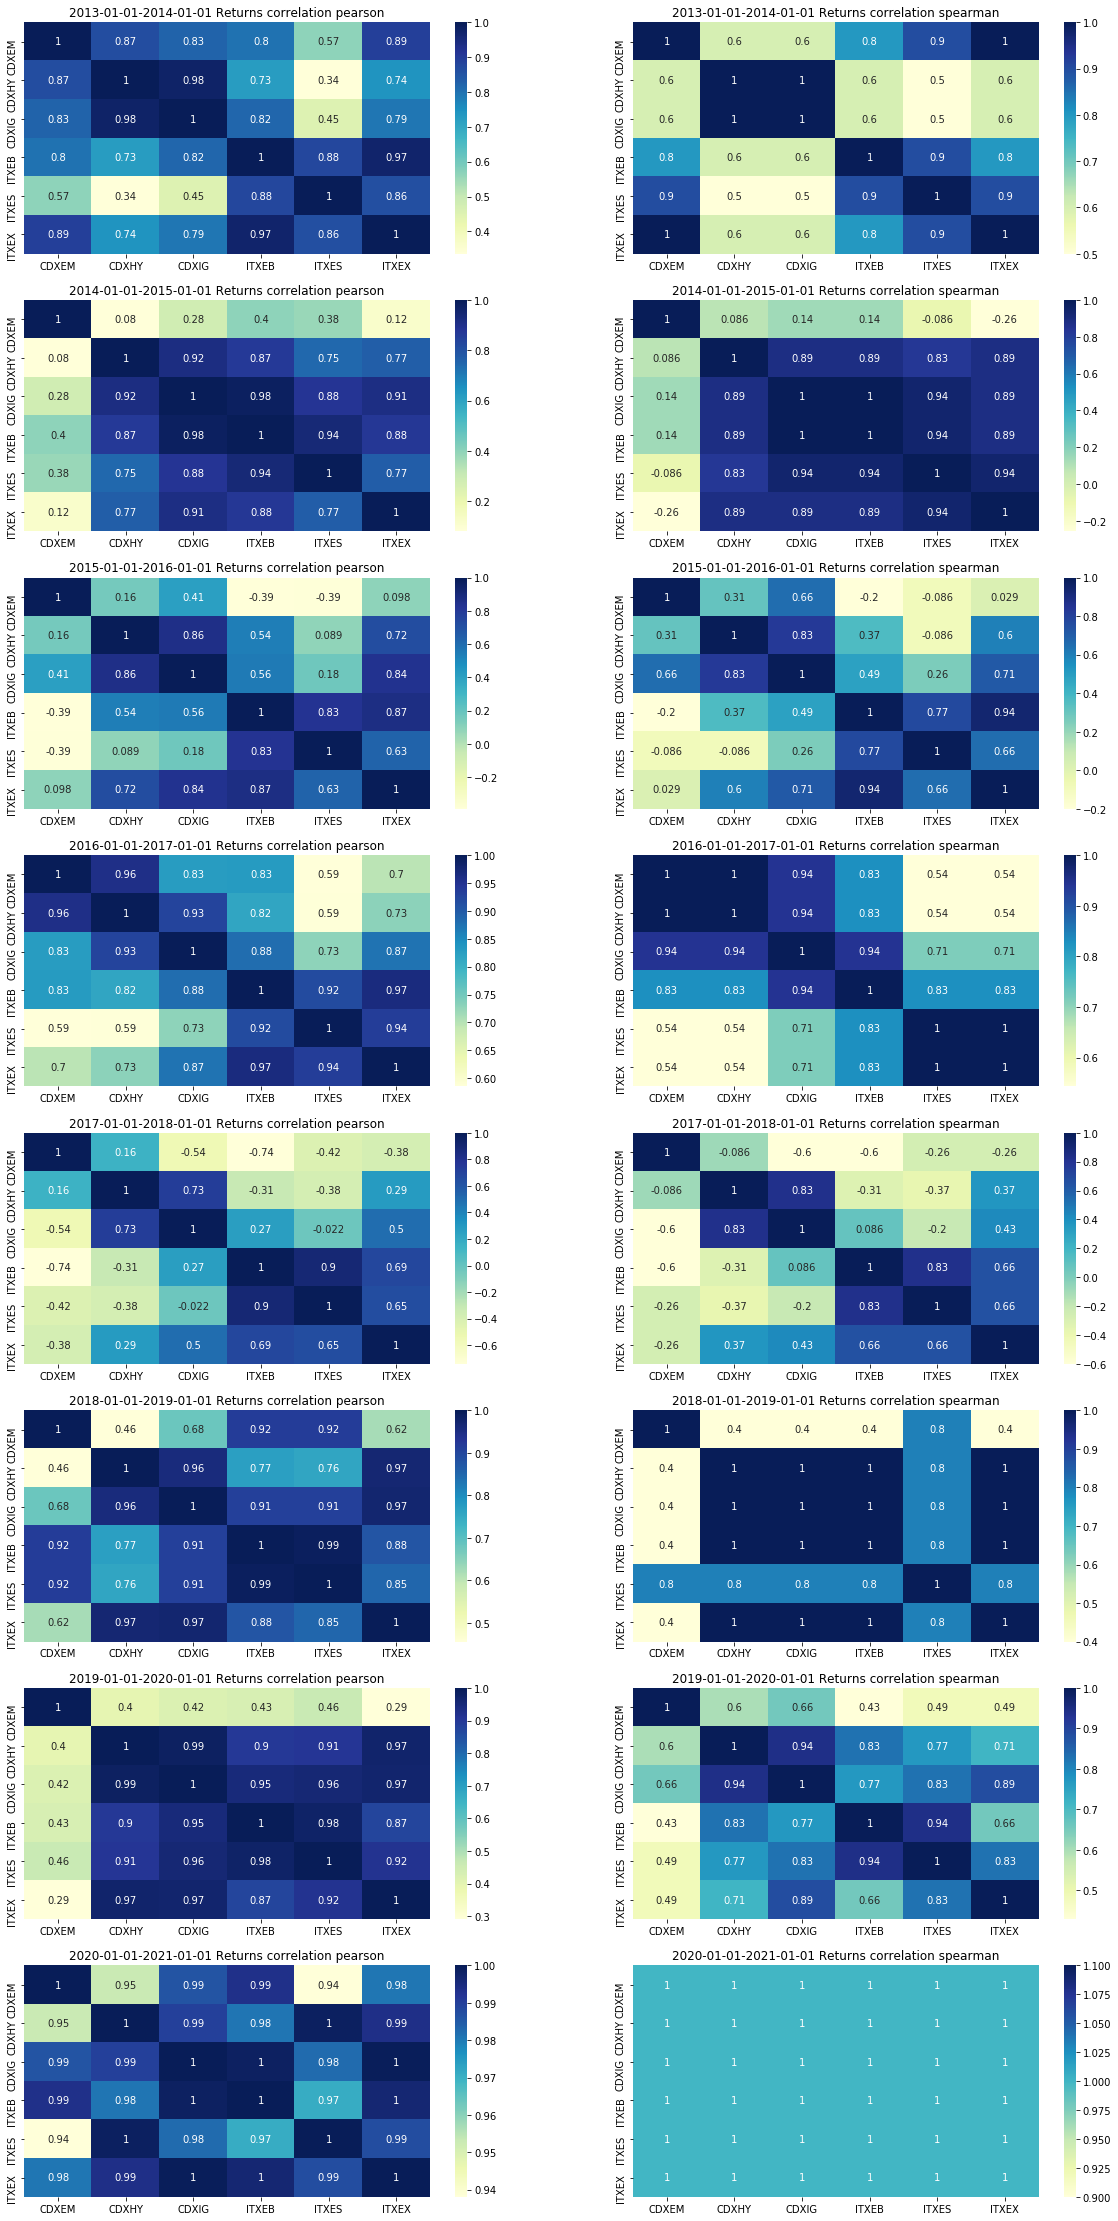

In [35]:
CorrelationYearlyHeatmap(df_return)

A few trends emerge from those heatmaps:
- Three blocks of correlated strucutres:
    - ITX families are heavily correlated upward of .9
    - CDX families are correlated with values hovering around .75
    - [CDXHY-CDXIG-ITXEB-ITXES-ITXEX] are correlated.
- CDXEM less correlated to other families with values oscillating arount 0.5-0.6.
- 2020: High correlation across the board.
- 2017: Lowest correlation CDX and ITX
- 2019: Low correlation CDX and  ITX, and really correlation between ITXEX and all other indices. 

### 2.4 Yearly Correlation Confidence Interval

In [36]:
def CorrelationYearlyConfidenceInterval(df):
    '''
    Computes the confidence interval for the yearly correlations
    Args:
        df: pandas df, Returns data frame
    Outputs:
        CI_dict: dict:
                    start_year: 
                        correlation coefficient: (pearson, spearman)
                            Confidence interval boundaries: (bootstrap results)
                                 Credit Index Swap Family used to compare:
                                    Credit Index Swap Family used to compare: [Lower bound, upper bound]
                            Confidence interval distance boundaries: (bootstrap results)
                                 Credit Index Swap Family used to compare:
                                    Credit Index Swap Family used to compare: [Dist Lower bound from correlation point, Dist upper bound from correlation poin]                  
        plots: yearly confidence interval plots for the returns correlation
    '''
    # Initialise return 
    CI_dict = dict()
    for year in range(8):
        # start date
        start = datetime.datetime(2013+year,1,1,0,0,0)
        # end date
        end = datetime.datetime(2014+year,1,1,0,0,0)
        temp = df.loc[(df.index > start) & (df.index < end),:]
        CI_dict[str(start.date())] = CorrelationPlots(temp, 1000, 5, ['spearman','pearson', 'pearson_fisher'], 1, str(start.date())+'_' +str(end.date()))
    return CI_dict

In [37]:
CI_yearly = CorrelationYearlyConfidenceInterval(df_return)

ValueError: Invalid RGBA argument: ' '

ValueError: Invalid RGBA argument: 'k '

<Figure size 720x1440 with 6 Axes>

## 3. Autocorrelation Returns

### 3.1. Autocorrelation Whole Data Set and Yearly data

We will anaylise the autocorrelation for each credit index swap family. This comes down to the following:
- Take returns and create another column with the returns shifted by 1.
- Find the correlation coefficient between those two columns. Computes the correlation between $R_{t}$ and $R_{t-1}$, where $R_{t}$ is the return at day t and $R_{t-1}$ at day t-1.
- Use a bootstrap method to create a confidence interval, create dataframe from $R_{t}$, $R_{t-1}$ columns by sampling with replacement those rows. Find the 2.5% percentile and 97.%% percentile for the confidence interval boundaries.

In [ ]:
# Plots autocorrelation of returns as function of lag
families = list(df_return.columns) 
fig, ax = plt.subplots(len(families))
for index, family in enumerate(families):
    autocorrelation_plot(df_return[family])
    plt.savefig('figures/autocorrelation_' + family + '.eps',format='eps' )
    plt.show()

In [ ]:
def BootstrapConfidenceIntervalAutocorrelation(df, B, alpha):
    '''
    Computes the bootstrap 95% confidence interval of the df dataframe for auto correlation
    Args:
        df: pandas df, dataframe to compute the CI from.
        B: int, number of iterations to compute 
        alpha: float, 100-alpha% confidence interval
    Returns:
        CI: list, lower and upper bound of the interval
    '''
    # initialise dict() for confidence interval
    CI = dict()
    # initialise dict() for correlation bootstrap
    BC = dict()
    
    # List of credit index swaps families to be studied
    families = list(df.columns)
    
    # Iterate B times 
    for i in range(B):
        # Iterate for each family
        for CIS in families:
            # Create shifted copy of specific credit index swap column
            name = CIS + '_1'
            temp = df.copy()
            temp[name] = df[CIS].shift(1)
            temp = temp.loc[:,[CIS,name]].dropna()
            temp = temp.sample(n = temp.shape[0], replace=True).corr()   
            correlation = temp.iloc[1,0]
            if CIS not in BC:           
                BC[CIS] = [correlation]
            else:
                BC[CIS].append(correlation)
    
    # Find the alpha/2 and 100-alpha/2 percentiles of correlation for each Credit index swap family 
    for CIS in BC:
        CI[CIS] = np.percentile(BC[CIS],[alpha/2,100-alpha/2])
    return CI
        

In [ ]:
def AucorrelationAnalysis(df, B, alpha):
    '''
    Computes the yearly and daily correlations for the data using the pearson's coefficeint as well as their confidence interval using bootsrtap
    Args:
        df: pandas, returns dataframe
        B: int, number of iterations for the bootstrap
        alpha: float, 100-alpha% comnfidence interval
    Outputs:
        autocorrelation_year_1:
            start date: dict()
                family: dict()
                    correlation
        autocorrelation_year:
        autocorrelation: dict()
            confidence: dict()
                family: dict()
                    [CI_lower, CI_upper]
            autocorrelation: dict()
                family: dict()
                    correlation whole dataset
        CI: confidence interval dict()
            year: dict()
                family: dict()
                    [CI_lower, CI_upper]
    '''
    # Autocorrelation by year
    autocorrelation_year = dict()
    # Autocorrelation by year 
    autocorrelation_year_1 = dict()

    # Autocorrelation for whole year
    autocorrelation = dict()
    # Confidence interval by year ofr each Credit Default index
    CI_year = dict()

    # Iterate for each family of credit default index
    for family in list(df.columns):
        # Print autocorrelation for each family oer whole dataset 
        print(str(family) + ': ' + str(df[family].autocorr(lag=1)))
        
        if 'autocorrelation' not in autocorrelation:
            autocorrelation['autocorrelation'] = dict()
            autocorrelation['autocorrelation'][family] = df[family].autocorr(lag=1)
        else:
            autocorrelation['autocorrelation'][family] = df[family].autocorr(lag=1)
        
        if 'confidence' not in autocorrelation:
            autocorrelation['confidence'] = BootstrapConfidenceIntervalAutocorrelation(df, B, alpha)
        
        # Iterate over each year from 2013 to 2020
        for i in range(8):      
            # Start year
            start = datetime.datetime(2013+i,1,1,0,0,0)
            # End year
            end = datetime.datetime(2014+i,1,1,0,0,0)
            # Select year to evaluate
            temp = df.loc[(df.index > start) & (df.index < end),:]
            # Compute Confidence interval for each family for each year
            CI_year[str(start)] = BootstrapConfidenceIntervalAutocorrelation(temp, B, alpha)
            # Compute Autocorrelation for the family index at a specific year
            print(str(start)+ ':' + str(end) + ', ' + str(family) + ': ' + str(temp[family].autocorr(lag=1)))

            # Autocorrelation by year and family
            if str(start) not in autocorrelation_year_1:
                autocorrelation_year_1[str(start)]= {family:temp[family].autocorr(lag=1)}                    
            else:
                autocorrelation_year_1[str(start)].update({family:temp[family].autocorr(lag=1)})

            # Save autocorrelation by family and year
            if family not in autocorrelation_year:
                autocorrelation_year[family] = [temp[family].autocorr(lag=1)]
            else:
                autocorrelation_year[family].append(temp[family].autocorr(lag=1)) 

            # Save dates
            if len(autocorrelation_year) <= 2:
                if 'dates' not in autocorrelation_year: 
                    autocorrelation_year['dates'] = [start]
                else:
                    autocorrelation_year['dates'].append(start)
    return autocorrelation_year_1, autocorrelation_year, autocorrelation, CI_year

In [ ]:
autocorrelation_year_1, autocorrelation_year, autocorrelation, CI_year = AucorrelationAnalysis(df_return, 1000, 5)

In [ ]:
autocorrelation

In [ ]:
def AutocorrelationYearlyPlots(autocorrelation, CI_year):
    '''
    Autocorrelation plots for CIS families
    Args:
        autocorrelation: dict():
                            year dict()
                                family dict()
                                    Autocorrelation coefficient
        CI_year: dict():
                    year dict()
                        [CI_lower, CI_upper]
    Outputs:
        Plots confidence intervals for autocorrelation 
    '''
    i = 0
    fig, ax = plt.subplots(len(CI_year), figsize = (15,30), sharex= True)
    for year in CI_year:
        x = list(autocorrelation[year].values())
        y = list(CI_year[year].keys())
        err = np.fabs(np.array(x).reshape(-1,6) - np.array(list(CI_year[year].values())).T)
        ax[i].errorbar(x, y, xerr = err, fmt = 'o', color = 'r')
        ax[i].set(xlabel="correlation", ylabel="Credit index swaps", title = year + ' autocorrelation confidence interval')
        ax[i].grid()
        i +=1
    plt.savefig('figures/yearly_autocorrelation.eps',format='eps')
    plt.show()
    

In [ ]:
AutocorrelationYearlyPlots(autocorrelation_year_1, CI_year)

In [ ]:
def LinePlotAutocorrelation(autocorrelation_year, CI_year, families):
    '''
    Plots the line plot of the evolution of autocorrelation per year as well as the confidence interval
    Args: 
        autocorrelation_year: dict()
            year: dict()
                family: dict()
                    correlation: float
        CI_year: dict()
            year: dict()
                family: dict()
                    confidence interval: np array floats: [CI lower, CI upper]
        families: list str, credit index swaps indices 
    Outputs:
        plots the line plot of the autocorrelation per year and their confidence interval 
    '''
    
    # iterate for each family
    for family in families: 
        years = list(CI_year.keys())
        # correlation
        y = []
        # confidence interval lower boundary
        CI_lower = []
        # confidence interval upper boundary
        CI_upper = []
        # iterate over the year
        for year in years:
            y.append(autocorrelation_year[year][family])
            CI_lower.append(CI_year[year][family][0])
            CI_upper.append(CI_year[year][family][1])
        # Plot autocorrelation for specific index over the years
        fig, ax = plt.subplots()
        for i, year in enumerate(years):
            years[i] = datetime.datetime.strptime(years[i], "%Y-%m-%d %H:%M:%S").date()
        # plot
        ax.plot(years,y)
        ax.fill_between(years, np.array(CI_lower), np.array(CI_upper), color='b', alpha=.1)
        ax.axhline(color='k')
        plt.grid()
        plt.ylabel('Autocorrelation Coefficient')
        plt.title( family + ' Autocorrelation with bootstrap confidence interval')
        plt.savefig('figures/' + family + '_AutoCorrelationLinePlots.eps',format='eps')
        plt.show()
    return

In [ ]:
LinePlotAutocorrelation(autocorrelation_year_1, CI_year, ['CDXEM', 'CDXHY', 'CDXIG', 'ITXEB', 'ITXES', 'ITXEX'])

In [ ]:
def AutocorrelationPlots(autocorrelation):
    '''
    Autocorrelation plots for CIS families
    Args:
        autocorrelation: dict():
                            year dict()
                                family dict()
                                    Autocorrelation coefficient
        CI_year: dict():
                    year dict()
                        [CI_lower, CI_upper]
    Outputs:
        Plots confidence intervals for autocorrelation 
    '''
    fig, ax = plt.subplots(sharex= True)
    x = list(autocorrelation['autocorrelation'].values())
    y = list(autocorrelation['autocorrelation'].values())
    err = np.fabs(np.array(x).reshape(-1,6) - np.array(list(autocorrelation['confidence'].values())).T)
    ax.errorbar(x, y, xerr = err, fmt = 'o', color = 'r')
    ax.set(xlabel="correlation", ylabel="Credit index swaps", title = ' autocorrelation confidence interval')
    ax.grid()
    plt.savefig('figures/autocorrelation.eps',format='eps')
    plt.show() 

In [ ]:
AutocorrelationPlots(autocorrelation)

In [ ]:
def YearlyAutcocorrelationHeatmap(df):
    '''
    Plots yearly autocrrelation heatmap
    Args:
        df: dict()
            year: dict()
                family: dict()
                    autcorrelation
    Outputs:
        Heatmap plot
    '''
    df: dict()
    df_autocorrelation = pd.DataFrame(df)
    df_autocorrelation['dates'] = df_autocorrelation['dates'].dt.date
    df_autocorrelation.set_index('dates', inplace=True)
    ax = sns.heatmap(df_autocorrelation.T, cmap= 'YlGnBu' )
    plt.xticks(rotation = 80)
    plt.savefig('figures/AutocorrelationYearlyHeatmap.eps',format='eps')
    plt.show()

In [ ]:
YearlyAutcocorrelationHeatmap(autocorrelation_year)

After analysis of the autocorrelation plots, it becomes apparent that there exists no autocorrelation for the returns. This is true for a yearly level as well as for the whole data set. This is due to the fact that the 95% confidence interval cuts the x-axis, so the correlation coefficient is not significant. However, there are a 7  exceptions where the autocorrelation is significant:
- $\textbf{CDXEM 2016}$: correlation 0.22, confidence interval [0.0675102 , 0.36379197]
- $\textbf{CDXHY 2014}$: correlation 0.22, confidence interval [0.09233261, 0.34110158]
- $\textbf{CDXIG 2015}$: correlation 0.19, confidence interval [0.07626659, 0.30102482]
- $\textbf{CDXIG 2016}$: correlation 0.19, confidence interval [0.02825479, 0.33613388]
- $\textbf{CDXIG 2017}$: correlation 0.11, confidence interval [0.00339736, 0.22068271]
- $\textbf{ITXEB 2019}$: correlation 0.15, confidence interval [0.01380979, 0.28793794]
- $\textbf{ITXES 2019}$: correlation 0.22, confidence interval [0.08246098, 0.34212454]

### 3.2 Autocorrelation per quantile

After analysing the plots by dates, we will focuse on the autocorrelation by quantile. The returns are split into their respective quantiles.

In [ ]:
def AutoCorrelationQuantile(df_return, quantiles):
    '''
    Computes quantiles autocorrelation with next day
    Args:
        df_return: pandas df, returns dataframe
        quantiles: int, split into that number of quantiles, eg: 10 = 10 quantiles
    Outputs:
        correlation: dict()
            family: dict()
                quantile: dict()
                    [correlation, np_array(CI_lower, CI_upper)]
    '''
    temp = df_return.copy()
    families = list(temp.columns)
    correlation = dict()
    
    for family in families:
        temp['quantiles_' + family] = pd.qcut(temp[family],quantiles, labels=False)
        temp['shift_' + family] = temp.loc[:,family].shift(-1)
        temp.dropna(inplace=True)
        # This one seems to work
        for j in range(quantiles):
            if j == 0:
                correlation[family]= {str(j+1) :[temp.loc[temp['quantiles_' + family]==j,[family, 'shift_' + family]].corr().iloc[0,1], BootstrapConfidenceInterval(temp.loc[temp['quantiles_' + family]==j,[family, 'shift_' + family]], 1000,'pearson', 5)[family]['shift_' + family]]}
            else:
                correlation[family].update({str(j+1) :[temp.loc[temp['quantiles_' + family]==j,[family, 'shift_' + family]].corr().iloc[0,1], BootstrapConfidenceInterval(temp.loc[temp['quantiles_' + family]==j,[family, 'shift_' + family]], 1000,'pearson', 5)[family]['shift_' + family]]})                
    return correlation

In [ ]:
def AutcoCorrelationQuantilePlots(df_return, quantiles):
    '''
    Args:
        df_return: pandas df, returns dataframe
        quantiles: int, split into that number of quantiles, eg: 10 = 10 quantiles
    Outputs:
        Plots AutoCorrelation per quantile for each family
        correlation: dict()
            family: dict()
                quantile: dict()
                    [correlation, np_array(CI_lower, CI_upper)]    '''
    
    # Define translation for plots
    translation = quantiles
    trans = [Affine2D().translate(0,0)]
    plus = 1
    minus = 1
    for i in range(1, translation):
        if i % 2 != 0:
            trans.append(Affine2D().translate(0, + plus * 0.1))
            plus += 1
        else:
            trans.append(Affine2D().translate(0, - minus * 0.1))
            minus += 1
    legend = []

    fig, ax = plt.subplots(1, figsize = (10,30), sharex = True) 
    # Compute correlation and CI for ea`ch family and their quantiles 
    correlation = AutoCorrelationQuantile(df_return, quantiles)
    # Plot errorbar for each quantile
    for quantile in range(quantiles):
        x = np.array([])
        y = list(correlation.keys()) 
        CI = np.array([])
        legend.append(str(quantile+1))
        for family in families:
            if len(x) == 0:
                x = np.array([correlation[family][legend[quantile]][0]])
            else:
                x = np.concatenate((x, np.array([correlation[family][legend[quantile]][0]])))
            if len(CI) == 0:
                CI = np.array([correlation[family][legend[quantile]][1]])
            else:
                CI = np.concatenate((CI, np.array([list(correlation[family][legend[quantile]][1])])))
        err = np.fabs(x-CI.T)
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        ax.errorbar(x, y, xerr = err, fmt = 'o', color = color, transform=trans[quantile] + ax.transData)
    ax.set(xlabel="correlation", ylabel="Credit index swaps", title = 'AutoCorrelation confidence interval by quantile')
    plt.legend(legend)
    plt.show()
    return correlation

In [ ]:
def AutcoCorrelationQuantilePlotsPerFamily(df_return, quantiles):
    '''
    Args:
        df_return: pandas df, returns dataframe
        quantiles: int, split into that number of quantiles, eg: 10 = 10 quantiles
    Outputs:
        Plots AutoCorrelation per quantile for each family
        correlation: dict()
            family: dict()
                quantile: dict()
                    [correlation, np_array(CI_lower, CI_upper)]    '''
    
    # Define translation for plots
    translation = quantiles
    trans = [Affine2D().translate(0,0)]
    plus = 1
    minus = 1
    for i in range(1, translation):
        if i % 2 != 0:
            trans.append(Affine2D().translate(0, + plus * 0.1))
            plus += 1
        else:
            trans.append(Affine2D().translate(0, - minus * 0.1))
            minus += 1
    legend = []

    fig, ax = plt.subplots(quantiles, figsize = (10,30), sharex = True) 
    # Compute correlation and CI for ea`ch family and their quantiles 
    correlation = AutoCorrelationQuantile(df_return, quantiles)
    # Plot errorbar for each quantile
    for quantile in range(quantiles):
        x = np.array([])
        y = list(correlation.keys()) 
        CI = np.array([])
        legend.append(str(quantile+1))
        for family in families:
            if len(x) == 0:
                x = np.array([correlation[family][legend[quantile]][0]])
            else:
                x = np.concatenate((x, np.array([correlation[family][legend[quantile]][0]])))
            if len(CI) == 0:
                CI = np.array([correlation[family][legend[quantile]][1]])
            else:
                CI = np.concatenate((CI, np.array([list(correlation[family][legend[quantile]][1])])))
        err = np.fabs(x-CI.T)
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        ax[quantile].errorbar(x, y, xerr = err, fmt = 'o')
        ax[quantile].set(xlabel="correlation", ylabel="Credit index swaps", title = 'AutoCorrelation confidence interval for Q' + str(quantile+1))
        ax[quantile].grid()
    plt.legend(legend)
    plt.show()
    return correlation

In [ ]:
def AutcoCorrelationQuantileLinePlotsPerFamily(df_return, families, quantiles):
    '''
    Args:
        df_return: pandas df, returns dataframe
        quantiles: int, split into that number of quantiles, eg: 10 = 10 quantiles
    Outputs:
        Plots AutoCorrelation per quantile for each family
        correlation: dict()
            family: dict()
                quantile: dict()
                    [correlation, np_array(CI_lower, CI_upper)]    '''
    

    # Compute correlation and CI for ea`ch family and their quantiles 
    correlation = AutoCorrelationQuantile(df_return, quantiles)
    # Plot errorbar for each quantile per family
    for index, family in enumerate(families):
        x = list(range(1,quantiles+1))
        y = []
        CI_lower = []
        CI_upper = []
        for quantile in range(quantiles):
            y.append(correlation[family][str(quantile+1)][0])
            CI_lower.append(correlation[family][str(quantile+1)][1][0])
            CI_upper.append(correlation[family][str(quantile+1)][1][1])
        #Plot autocorrelation for specific index over the years
        fig, ax = plt.subplots() 
        ax.plot(x,y)
        ax.fill_between(x, np.array(CI_lower), np.array(CI_upper), color='b', alpha=.1)
        ax.axhline(color='k')
        ax.grid()
        ax.set(xlabel="quantile", ylabel="Autocorrelation", title = family + ' Autocorrelation per quantile')    
        plt.savefig('figures/' + family + '_AutoCorrelationQuantileLinePlots.eps',format='eps')
    plt.show()
        
    return correlation

In [ ]:
correlation = AutoCorrelationQuantile(df_return, 10)

In [ ]:
correlation = AutcoCorrelationQuantileLinePlotsPerFamily(df_return, ['CDXEM', 'CDXHY', 'CDXIG', 'ITXEB', 'ITXES', 'ITXEX'], 10)

In [ ]:
correlation = AutcoCorrelationQuantilePlotsPerFamily(df_return, 10)

There is no autocorrelation per quantile as the confidence interval intersects the xaxis for all families for each quantiles.

## 4. Normality of Returns

### 4.1 Whole Dataset

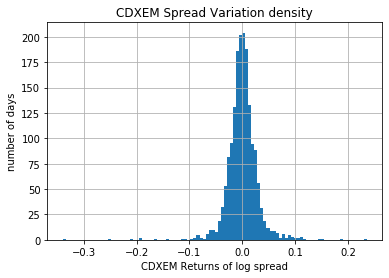

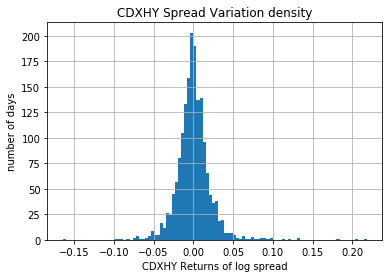

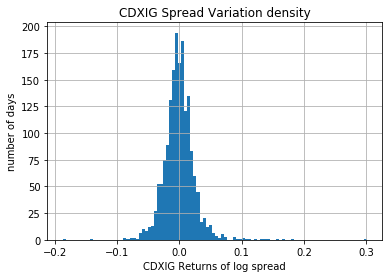

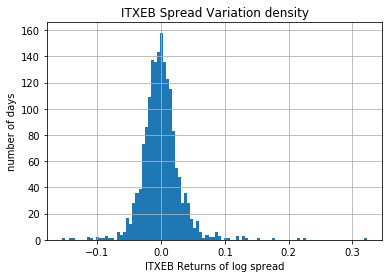

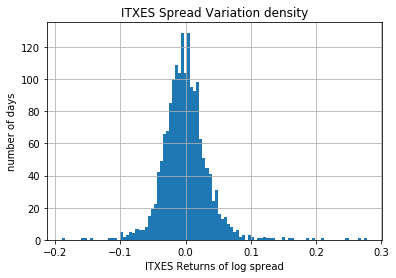

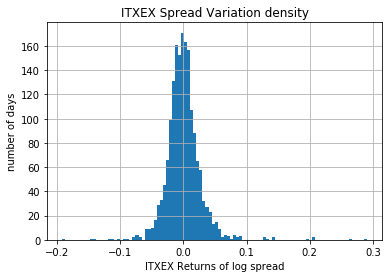

In [64]:
# Plot Returns density distribution
families = list(df_return.columns)
for index, family in enumerate(families):
    fig, ax = plt.subplots()
    ax.hist(df_return.loc[:,family], bins = 100)
    ax.set(xlabel = family + ' Returns of log spread', ylabel = 'number of days', title = family + ' Spread Variation density')
    ax.grid()
    plt.savefig('figures/'+ family +'_CIS_returns.eps',format='eps')
plt.show()

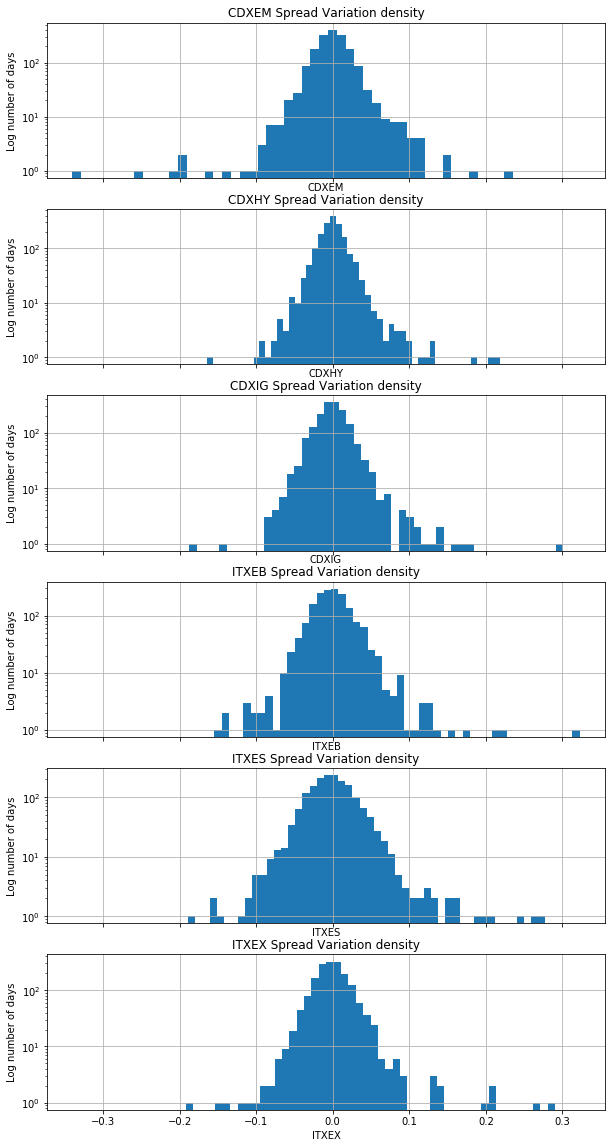

In [59]:
# Plot Returns density distirbution on ylog scale
families = list(df_return.columns)
fig, ax = plt.subplots(6, figsize =(10,20), sharex=True)
for index, family in enumerate(families):
    ax[index].hist(df_return[family], bins = 50)
    ax[index].set(xlabel = family, ylabel = 'Log number of days', title = family + ' Spread Variation density', yscale='log')
    ax[index].grid()
plt.show()

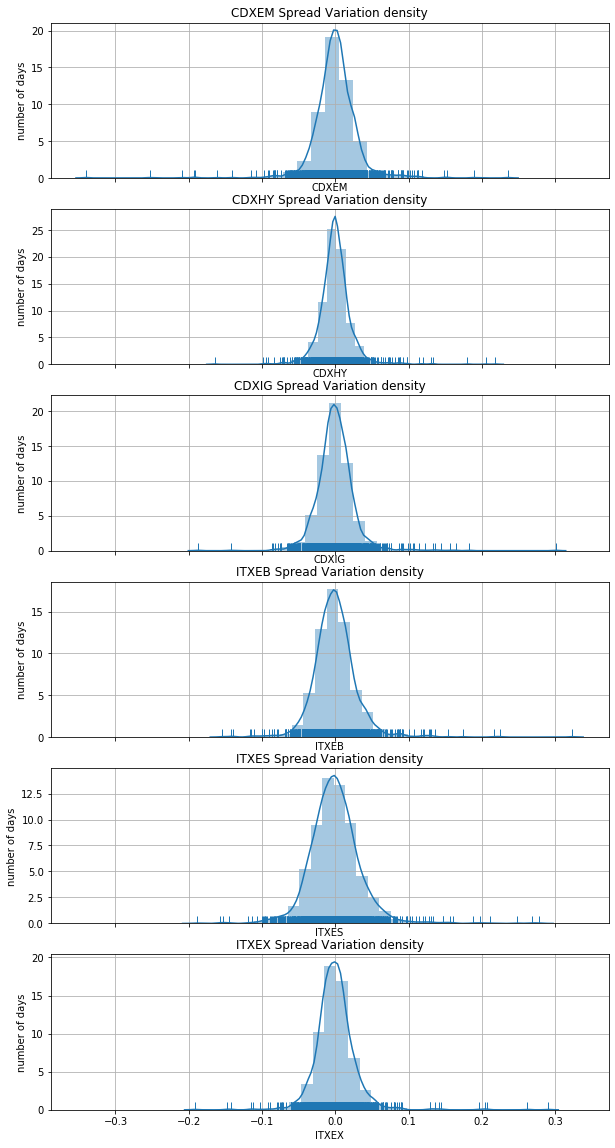

In [60]:
# Plot Returns density distrbiution with density curve 
families = list(df_return.columns)
fig, ax = plt.subplots(6, figsize =(10,20), sharex= True)
ks = dict()
for index, family in enumerate(families):
    sns.distplot(df_return[family], bins=30, kde=True, rug=True, ax= ax[index])
    ax[index].set(xlabel = family, ylabel = 'number of days', title = family + ' Spread Variation density')
    ax[index].grid()
    loc, scale = scipy.stats.norm.fit(df_return.loc[:,family])
    # create a normal distribution with loc and scale
    n = scipy.stats.norm(loc=loc, scale=scale)
    # Kolmogorov–Smirnov test to test if normal
    ks[family] = scipy.stats.kstest(df_return.loc[:,family], n.cdf)
plt.show()

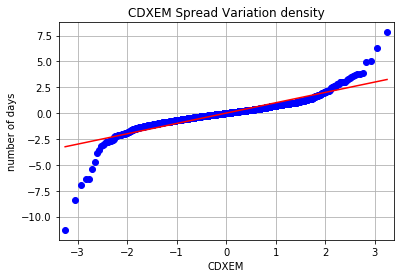

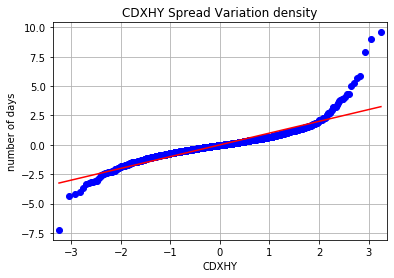

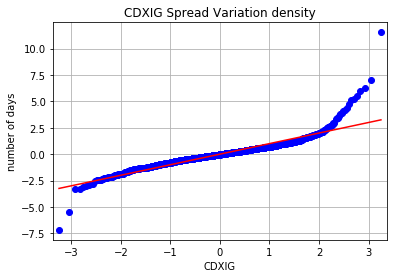

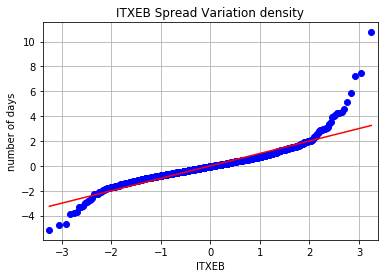

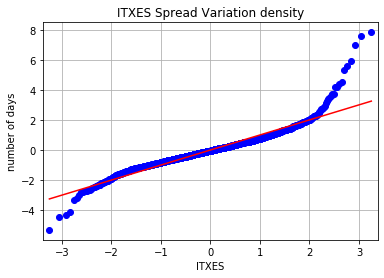

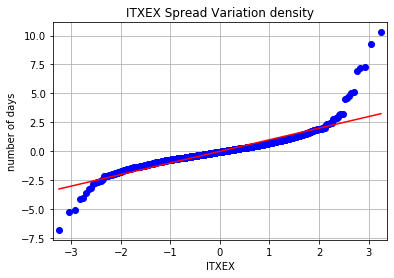

In [61]:
# test if normal with Q-Q Plot
families = list(df_return.columns)

for index, family in enumerate(families):
    sm.qqplot(df_return[family], fit=True, line = 's')
    plt.xlabel(family)
    plt.ylabel('number of days')
    plt.title(family + ' Spread Variation density')
    plt.grid()
    plt.savefig('figures/' + family + '_CIS_qqplot.eps',format='eps')
plt.show()

In [62]:
ks

{'CDXEM': KstestResult(statistic=0.08800819999850917, pvalue=3.900832106586257e-12),
 'CDXHY': KstestResult(statistic=0.10122975278709967, pvalue=6.371360757777439e-16),
 'CDXIG': KstestResult(statistic=0.08625234084346811, pvalue=1.1324430708682441e-11),
 'ITXEB': KstestResult(statistic=0.08033304596256319, pvalue=3.510025134529256e-10),
 'ITXES': KstestResult(statistic=0.0710146446169343, pvalue=4.756946690168593e-08),
 'ITXEX': KstestResult(statistic=0.08995487485637743, pvalue=1.1668893552415205e-12)}

According to the histogram results the daily spread variation is normally distributed, however a lot of outliers seem to be affecting the results. After analyis the quantile-quantile plots of those distributions, it becomes apparent that the spread variation over the whole dataset for each credit index swap family is a heavy tailed distirbution. Moreover, the Kolmogorov Smirnov test further justifies that the test is statistically significsnt, so we can reject the hypothesis that the distribution is normal.

### 4.3. Yearly results

In [ ]:
ks_results = dict()
for i in range(8):
    # Start year
    start = datetime.datetime(2013+i,1,1,0,0,0)
    ks_results[str(start)] = dict()
    # End year
    end = datetime.datetime(2014+i,1,1,0,0,0)
    # Select year to evaluate
    temp = df_return.loc[(df_return.index > start) & (df_return.index < end),:]
    families = list(temp.columns)
    fig, ax = plt.subplots(6, figsize =(10,20))
    for index, family in enumerate(families):
        loc, scale = scipy.stats.norm.fit(df_return.loc[:,family])
        # create a normal distribution with loc and scale
        n = scipy.stats.norm(loc=loc, scale=scale)
        ks_results[str(start)][family] = scipy.stats.kstest(temp.loc[:,family],n.cdf)
        sm.qqplot(temp.loc[:,family], fit=True, line = 's',ax= ax[index])
        ax[index].set(xlabel = family, ylabel = 'number of days', title = str(start.date()) + ': ' + family + ' Spread Variation density')
        ax[index].grid()
    plt.tight_layout()
    

In [ ]:
ks_results

After analysing the results, there are a few years that we can say that the close to close returns follow a normal distirbution. These are the following:
- CDXEM: 2013
- CDXEM: 2018
- CDXIG: 2016
- ITXEB: 2015
- ITXEB: 2016
- ITXES: 2015
- ITXES: 2016
- ITXES: 2018
- ITXES: 2020
- ITXEX: 2014
- ITXEX: 2015

## 5. Variance and Standard Deviation

### 5.1. Whole dataset

In [ ]:
columns = (df_return.columns)
close_close_stats = dict(dict())
for index, column in enumerate(columns):
    mean_col = df_return[column].mean()
    df_standard_deviation = pd.DataFrame(df_return[column].apply(lambda x: (x-mean_col)**2))
    close_close_variance = df_standard_deviation.sum()/df_standard_deviation.shape[0]
    close_close_standard_deviation = np.sqrt(close_close_variance)
    if index == 0:
        close_close_stats['total'] = {column:{'variance': close_close_variance[0], 'standard_deviation':close_close_standard_deviation[0]}}
    else:
        close_close_stats['total'].update({column:{'variance': close_close_variance[0], 'standard_deviation':close_close_standard_deviation[0]}})

In [ ]:
close_close_stats

#### 5.2.2 Yearly

In [ ]:
columns = (df_return.columns)
for year in range(8):
    start = datetime.datetime(2013+year,1,1,0,0,0)
    end =  datetime.datetime(2014+year,1,1,0,0,0)
    for index, column in enumerate(columns):
        mean_col = df_return.loc[(df_return.index >start) & (df_return.index < end),column].mean()
        df_standard_deviation = pd.DataFrame(df_return.loc[(df_return.index >start) & (df_return.index < end),column].apply(lambda x: (x-mean_col)**2))
        close_close_variance = df_standard_deviation.sum()/df_standard_deviation.shape[0]
        close_close_standard_deviation = np.sqrt(close_close_variance)
        if index == 0:
            close_close_stats[start.date()] = {column:{'variance': close_close_variance[0], 'standard_deviation':close_close_standard_deviation[0]}}
        else:
            close_close_stats[start.date()].update({column:{'variance': close_close_variance[0], 'standard_deviation':close_close_standard_deviation[0]}})

In [ ]:
close_close_stats

In [ ]:
columns = ['CDXEM', 'CDXHY', 'CDXIG', 'ITXEB', 'ITXES', 'ITXEX']
fig, ax = plt.subplots(6, figsize=(10,20))
for index, family in enumerate(columns):
    std_dv = []
    date = []
    overall_std_dv = close_close_stats['total'][family]['standard_deviation']
    for i in range(8):
        std_dv.append(close_close_stats[datetime.date(2013+i,1,1)][family]['standard_deviation'])
        date.append(datetime.date(2013+i,1,1))
    ax[index].plot(date, std_dv)
    ax[index].axhline(y=overall_std_dv, color = 'r')
    ax[index].legend(['yearly standard deviation', 'whole standard deviation'])
    ax[index].set(xlabel='date', ylabel='standard deviation', title= family+ ' standard deviation')
    ax[index].grid()
plt.tight_layout()
plt.savefig('figures/standard_deviation.eps', format='eps')